In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_2_1'

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%sh -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length

In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6163 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6163 bytes


In [5]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [6]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)
print(key)

N = 2500
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 
    
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


C:\Users\dynko\AppData\Local\Temp\ipykernel_16136\1793369270.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/2500 [00:00<?, ?it/s]

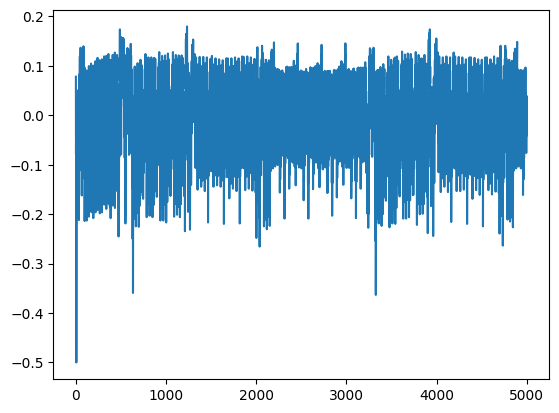

In [11]:
import matplotlib.pyplot as plt
plt.plot(trace_array[4])

In [7]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit, most likely LSB
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

In [8]:
#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tnrange(0, 16, desc="Attacking Subkey"): #aka each byte
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

C:\Users\dynko\AppData\Local\Temp\ipykernel_16136\2526881713.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"): #aka each byte


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 0.006352
   DE - Diff = 0.002860
   BF - Diff = 0.002836
   43 - Diff = 0.002763
   FF - Diff = 0.002600


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 0.004388
   1B - Diff = 0.002670
   80 - Diff = 0.002533
   61 - Diff = 0.002398
   15 - Diff = 0.002398


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.004436
   A8 - Diff = 0.002858
   2B - Diff = 0.002779
   E0 - Diff = 0.002751
   B2 - Diff = 0.002649


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 0.003545
   73 - Diff = 0.002915
   5C - Diff = 0.002622
   96 - Diff = 0.002456
   E4 - Diff = 0.002428


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 0.005613
   FC - Diff = 0.002944
   8F - Diff = 0.002679
   BA - Diff = 0.002625
   95 - Diff = 0.002532


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.003490
   96 - Diff = 0.002470
   C5 

In [9]:
scope.dis()
target.dis()